# Moneza-Loan-Approval-Automation


## Data Cleaning and Preprocessing

### 1. Import Libraries and Functions

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.io as pio
pio.renderers.default = 'notebook'

# Import custom functions from the src folder
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from visualization import create_bar_chart
from utils import get_categorical_columns,get_numerical_columns,convert_to_data_type,get_boolean_columns



### 2. Read Data

In [2]:
# Load the Excel file
file_path = "../data/raw/TWINO_task_data_scientist.xlsx"

data = pd.read_excel(file_path,sheet_name="Data")

### 3. Data Cleaning

#### 3.1 Standardize Data Types and Formats

In [3]:
categorical_columns = get_categorical_columns(data)
boolean_columns=get_boolean_columns(data)

# Convert all text data to lowercase
data[categorical_columns] = data[categorical_columns].apply(lambda x: x.str.lower().str.strip())
data[categorical_columns] = convert_to_data_type(data,categorical_columns,"category")
data[boolean_columns] = convert_to_data_type(data,boolean_columns,"int")
data[boolean_columns] = convert_to_data_type(data,boolean_columns,"category")

#Convert AR  to category
data["AR"] = convert_to_data_type(data,"AR","category")



#### 3.2 Check for missing data

In [4]:
# Calculate the percentage of missing values for each column in the DataFrame
null_percentage_columns = data.isna().mean() * 100
null_percentage_columns = null_percentage_columns.sort_values(ascending=False)

null_percentage_columns

application_id                   0.0
AR                               0.0
data_quality_19                  0.0
data_quality_20                  0.0
other_21                         0.0
other_22                         0.0
data_quality_23                  0.0
data_quality_24                  0.0
data_quality_25                  0.0
data_quality_26                  0.0
data_quality_27                  0.0
data_quality_28                  0.0
other_29                         0.0
data_quality_30                  0.0
other_31                         0.0
data_quality_32                  0.0
data_quality_33                  0.0
data_quality_34                  0.0
data_quality_35                  0.0
other_36                         0.0
accounts_check_37                0.0
creditcard_check_18              0.0
creditcard_check_17              0.0
creditcard_check_16              0.0
accounts_check_5                 0.0
payment_method                   0.0
client_first_lapp_mark           0.0
c

##### Missing Data Findings
- **Findings:** There are no missing values in any of the columns in the dataset.
- **Action:** No action required as the dataset is complete.

#### 3.3 Check for duplicates

In [5]:
# Check for any duplicate rows
duplicates = data.duplicated()
duplicate_count = duplicates.sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    duplicate_rows = data[duplicates]
    display(duplicate_rows)

Number of duplicate rows: 0


##### Duplicate Data Findings
- **Findings:** There are no duplicate rows in the dataset.
- **Action:** No action required as there are no duplicates.

#### 3.3 Check for outliers

In [6]:
#Drop application_id column
data = data.drop("application_id", axis = 1)
numerical_columns = get_numerical_columns(data)

# Interquartile Range (IQR) method
Q1 = data['warning_count'].quantile(0.25)
Q3 = data['warning_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
iqr_outliers = data[(data['warning_count'] < lower_bound) | (data['warning_count'] > upper_bound)]
print("Number of IQR outliers:", len(iqr_outliers))

# Z-Score method
z_scores = stats.zscore(data['warning_count'])
z_score_outliers = data[abs(z_scores) > 3]
print("Number of Z-score outliers:", len(z_score_outliers))

# Combine outliers
combined_outliers_index = iqr_outliers.index.union(z_score_outliers.index)
num_combined_outliers = len(combined_outliers_index)
print("Number of combined outliers:", num_combined_outliers)
combined_outliers = data.loc[combined_outliers_index]



Number of IQR outliers: 24
Number of Z-score outliers: 52
Number of combined outliers: 52


In [7]:
combined_outliers_index = iqr_outliers.index.union(z_score_outliers.index)

# Number of combined outliers
num_combined_outliers = len(combined_outliers_index)
print("Number of combined outliers:", num_combined_outliers)

# Extract the combined outliers
combined_outliers = data.loc[combined_outliers_index]
combined_outliers.warning_count.value_counts()

Number of combined outliers: 52


warning_count
13    28
14    17
15     6
16     1
Name: count, dtype: int64

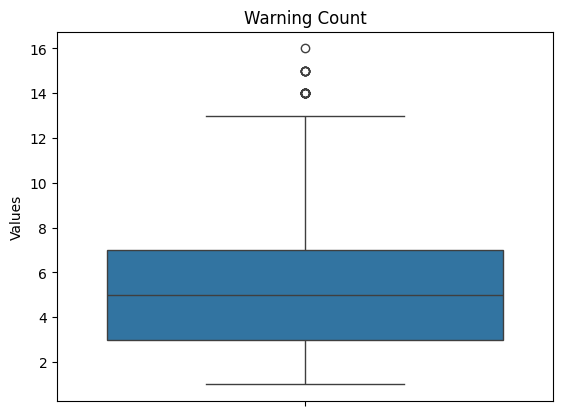

In [8]:
sns.boxplot(data['warning_count'])
plt.title('Warning Count')
plt.ylabel('Values')

plt.savefig("../reports/figures/warning_count_outliers.png")
plt.show()

In [9]:
combined_outliers.warning_count.unique()

array([14, 13, 15, 16])

##### Outliers Findings
- **Methodology:**
  - **Interquartile Range (IQR):** Outliers are defined as data points outside 1.5 times the IQR above Q3 or below Q1. This method identified 24 outliers in the `warning_count` column.
  - **Z-Score:** Outliers are defined as data points with a Z-score greater than 3 or less than -3. This method identified 52 outliers in the `warning_count` column.
  - **Combined Approach:** Combining the outliers identified by both IQR and Z-score methods, a total of 52 unique outliers were observed.
- **Findings:**
  - 52 outliers were identified out of 9,898 records.
  - I am going by the assumption that the outlier values (14, 13, 15, 16) are  reasonable and possible in real-life scenarios. Therefore, they are treated as edge cases rather than anomalies.
- **Action:** The outliers will be retained in the dataset for further analysis.

In [10]:
# Define a colormap
from matplotlib.colors import LinearSegmentedColormap


royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
royalblue_r = royalblue.reversed()

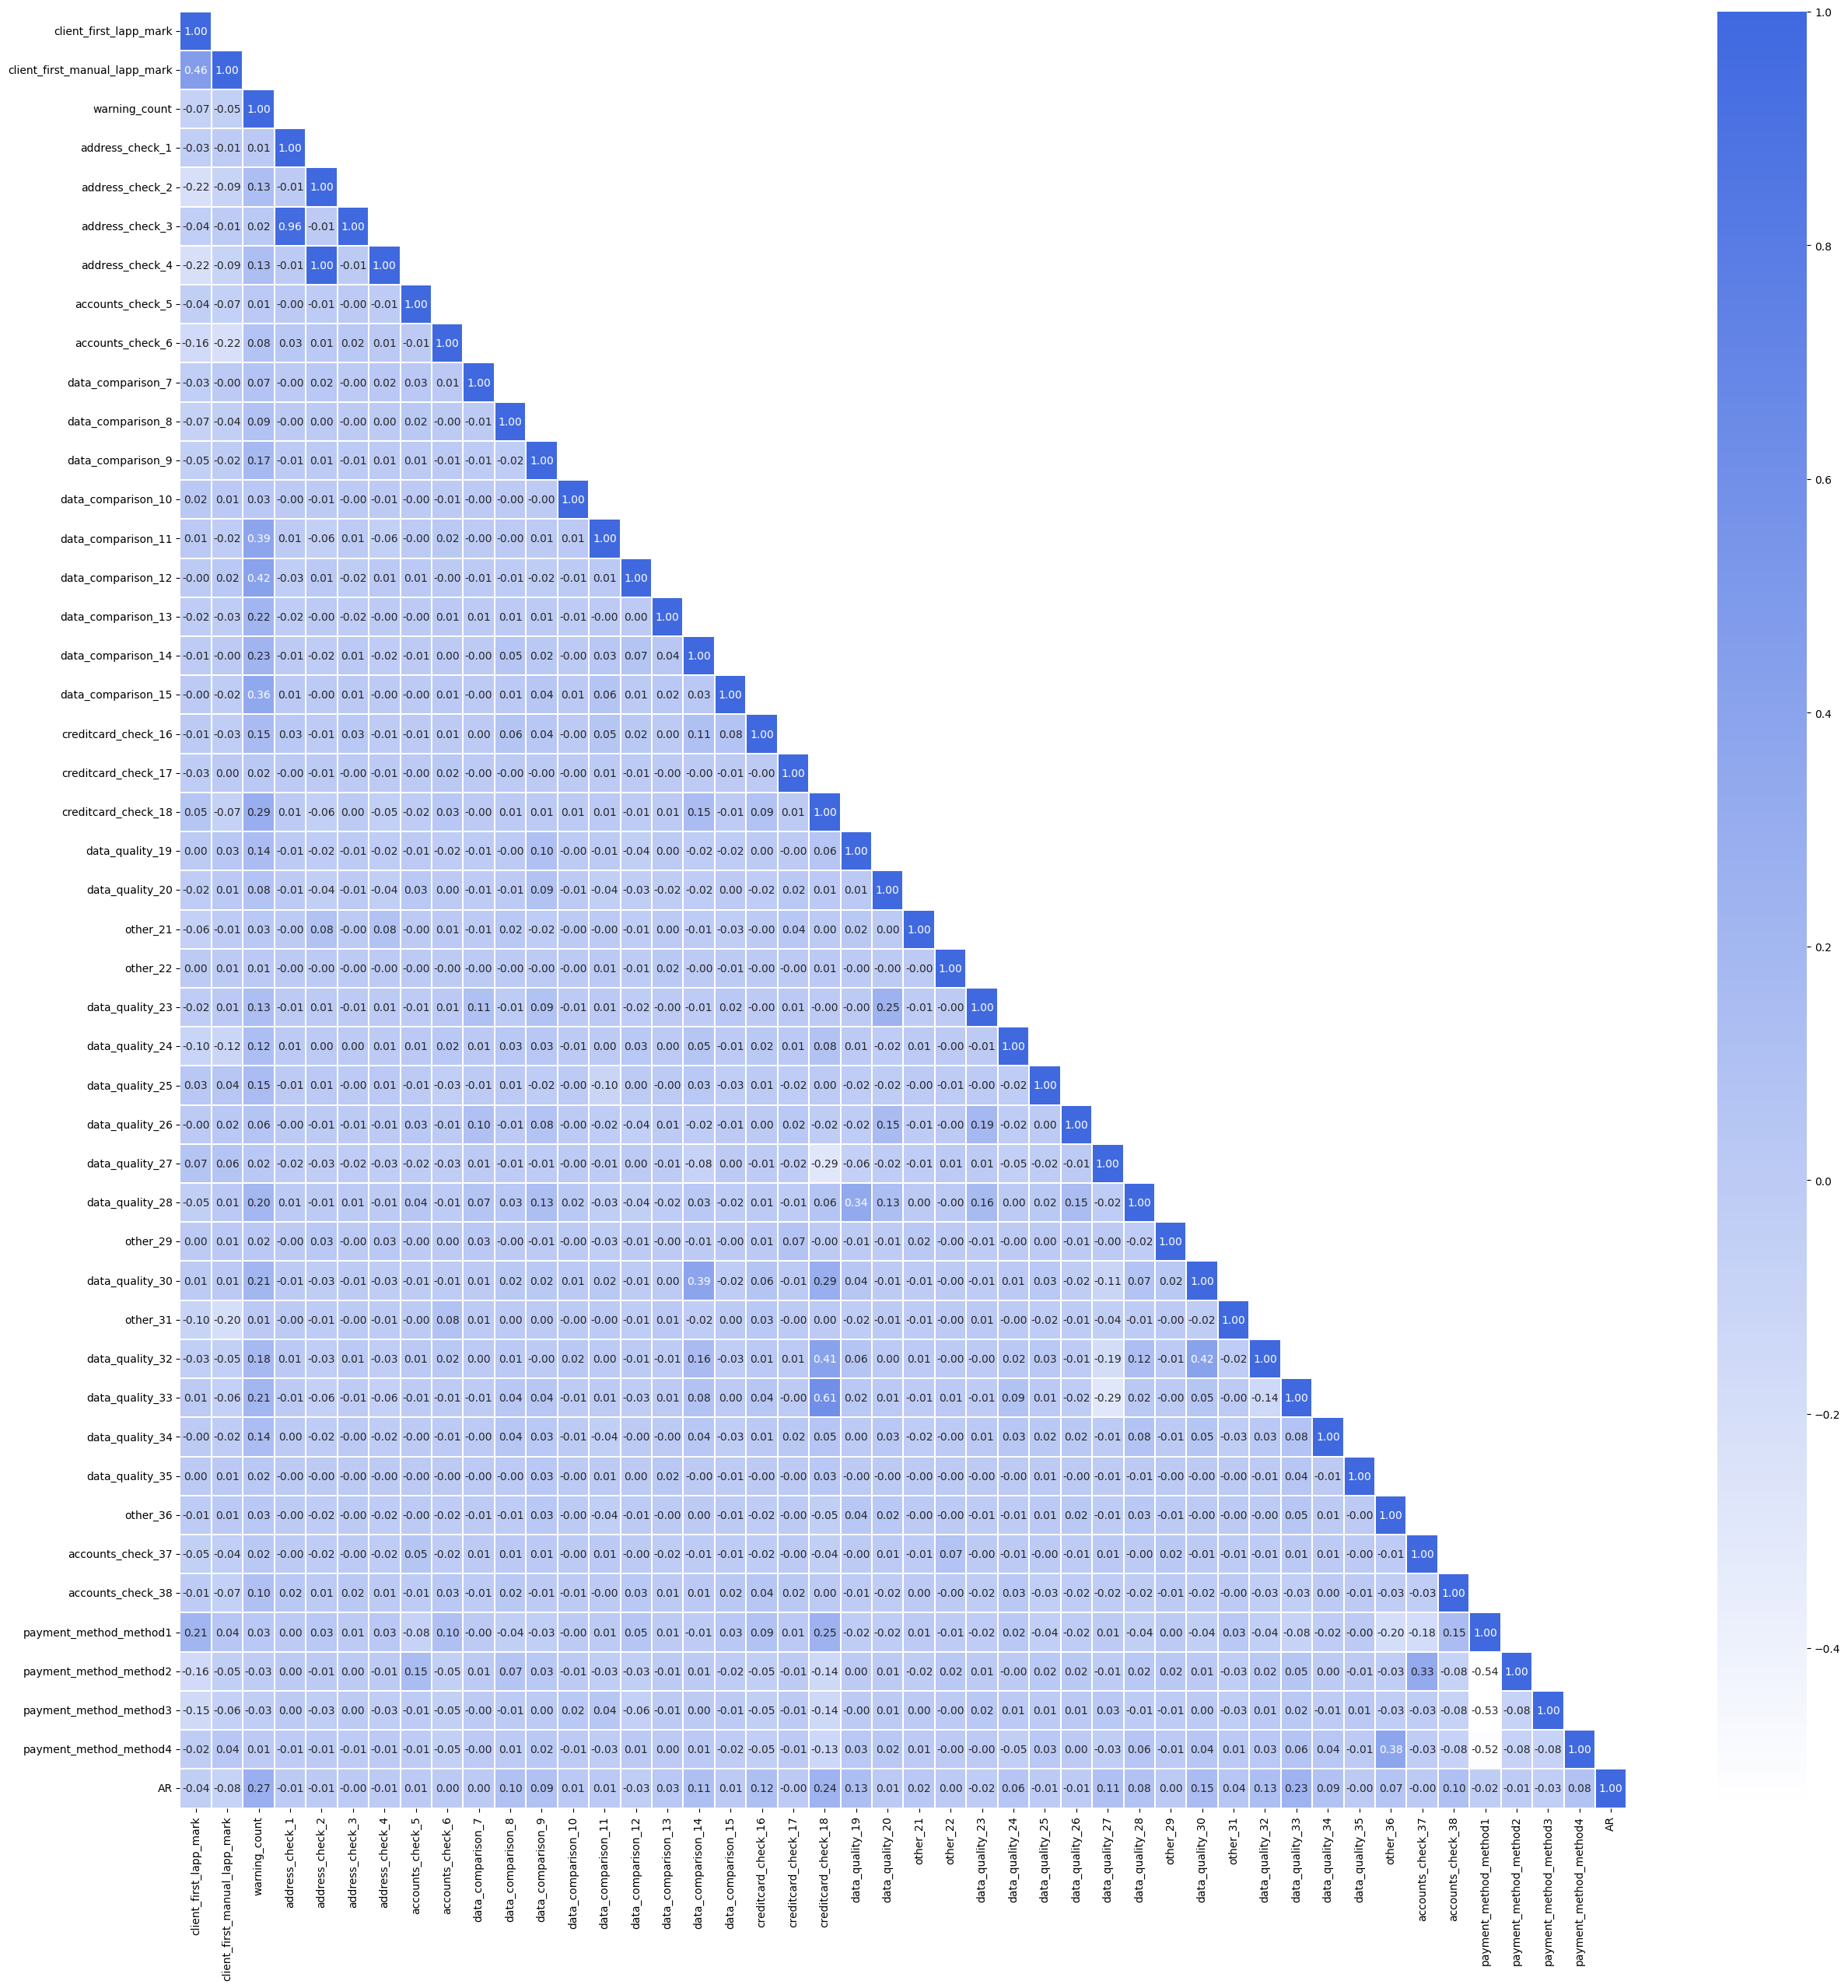

In [11]:
# Calculation of the Spearman correlation
import numpy as np
from sklearn.calibration import LabelEncoder

spearman=data.copy()
label_encoder = LabelEncoder()

# encode the categorical columns
for category in get_categorical_columns(spearman):
    if category !="payment_method":
        spearman[category]= label_encoder.fit_transform(spearman[category])
spearman=pd.get_dummies(spearman,dtype='int64')

target = 'AR'
df_ordered = pd.concat([spearman.drop(target,axis=1), spearman[target]],axis=1)
corr = df_ordered.corr(method='spearman')

# Create a mask so that we see the correlation values only once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

# Plot the heatmap correlation
plt.figure(figsize=(30,30))
sns.heatmap(corr, mask=mask, annot=True, cmap=royalblue, fmt='.2f', linewidths=0.2)
plt.show()

### 4. Save cleaned data

In [12]:
# save as parquet to persist data types
data.to_parquet("../data/processed/data_cleaned.pqt",index=False)